In [2]:
here::i_am("rna_atac/dimensionality_reduction/01_WNN_MOFA.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(batchelor))

BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

# Multi core using future - built in to seurat
plan("multicore", workers = 1)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code



In [10]:
args = list()
args$metadata =  sprintf('%s/results/rna_atac/combined_metadata.txt.gz',io$basedir)

# ATAC
args$atac_umap = file.path(io$basedir, 'results/atac/archR/dimensionality_reduction/cells/PeakMatrix/remove_ExE_cells_FALSE/batch_correction_None/umap_nfeatures25000_dims20_nneighbour25_mindist0.3.txt.gz')

# RNA
args$rna_umap = file.path(io$basedir, 'results/rna/dimensionality_reduction/sce/none/umap_features1500_pcs15_neigh25_dist0.3.txt.gz')

# MOFA
args$mofa_umap = sprintf('%s/results/rna_atac/dimensionality_reduction/mofa/MOFA_umap.txt.gz', io$basedir)

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/dimensionality_reduction/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [48]:
dot_size = 5
text_size = 15
title_size = 20

plot_umap = function(umap.dt){
    # Plot umap
    p1 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=exp)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=c('exp1' = 'deepskyblue', 'exp2' = 'salmon'), name='') +
        guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
        ggtitle('Experiment') +
        theme_void() +
        theme(text=element_text(size=text_size), 
             plot.title=element_text(size=title_size), 
             legend.position='bottom')

    umap.dt$day_genotype = paste0(umap.dt$day, '-', umap.dt$genotype)
    umap.dt$day_genotype = gsub('KO', 'KD', umap.dt$day_genotype)
    umap.dt$day_genotype = factor(umap.dt$day_genotype, levels=c('D3-WT','D3.5-WT','D3.5-KD','D4-WT','D4-KD','D4.5-WT','D4.5-KD','D5-WT','D5-KD'))

    # Plot umap
    p2 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=day_genotype)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=c('D3-WT' = 'purple', 
                                    'D3.5-WT' = 'darkgreen', 
                                    'D3.5-KD' = 'limegreen',
                                    'D4-WT' = 'darkgoldenrod', 
                                    'D4-KD' = 'gold',
                                    'D4.5-WT' = 'darkblue',
                                    'D4.5-KD' = 'deepskyblue', 
                                    'D5-WT' = 'darkred',
                                    'D5-KD' = 'red'
                                   ), name='') +
        guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
        #ggtitle('Day-Genotype') +
        theme_void() +
        theme(text=element_text(size=text_size), 
             plot.title=element_text(size=title_size), 
             legend.position='none')

    # Plot umap
    p3 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=genotype)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=opts$genotype.colors, name='') + 
        guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
        #ggtitle('Genotype') +
        theme_void() +
        theme(text=element_text(size=text_size), 
             plot.title=element_text(size=title_size), 
             legend.position='none')

    #options(repr.plot.width=6, repr.plot.height=12)
    plots = ggarrange(p2, p3, ncol=1)
    return(plots)
}

In [43]:
meta = fread(args$metadata)
rna_umap = fread(args$rna_umap)
atac_umap = fread(args$atac_umap) %>% setnames(c('cell', 'UMAP1', 'UMAP2'))
mofa_umap = fread(args$mofa_umap)

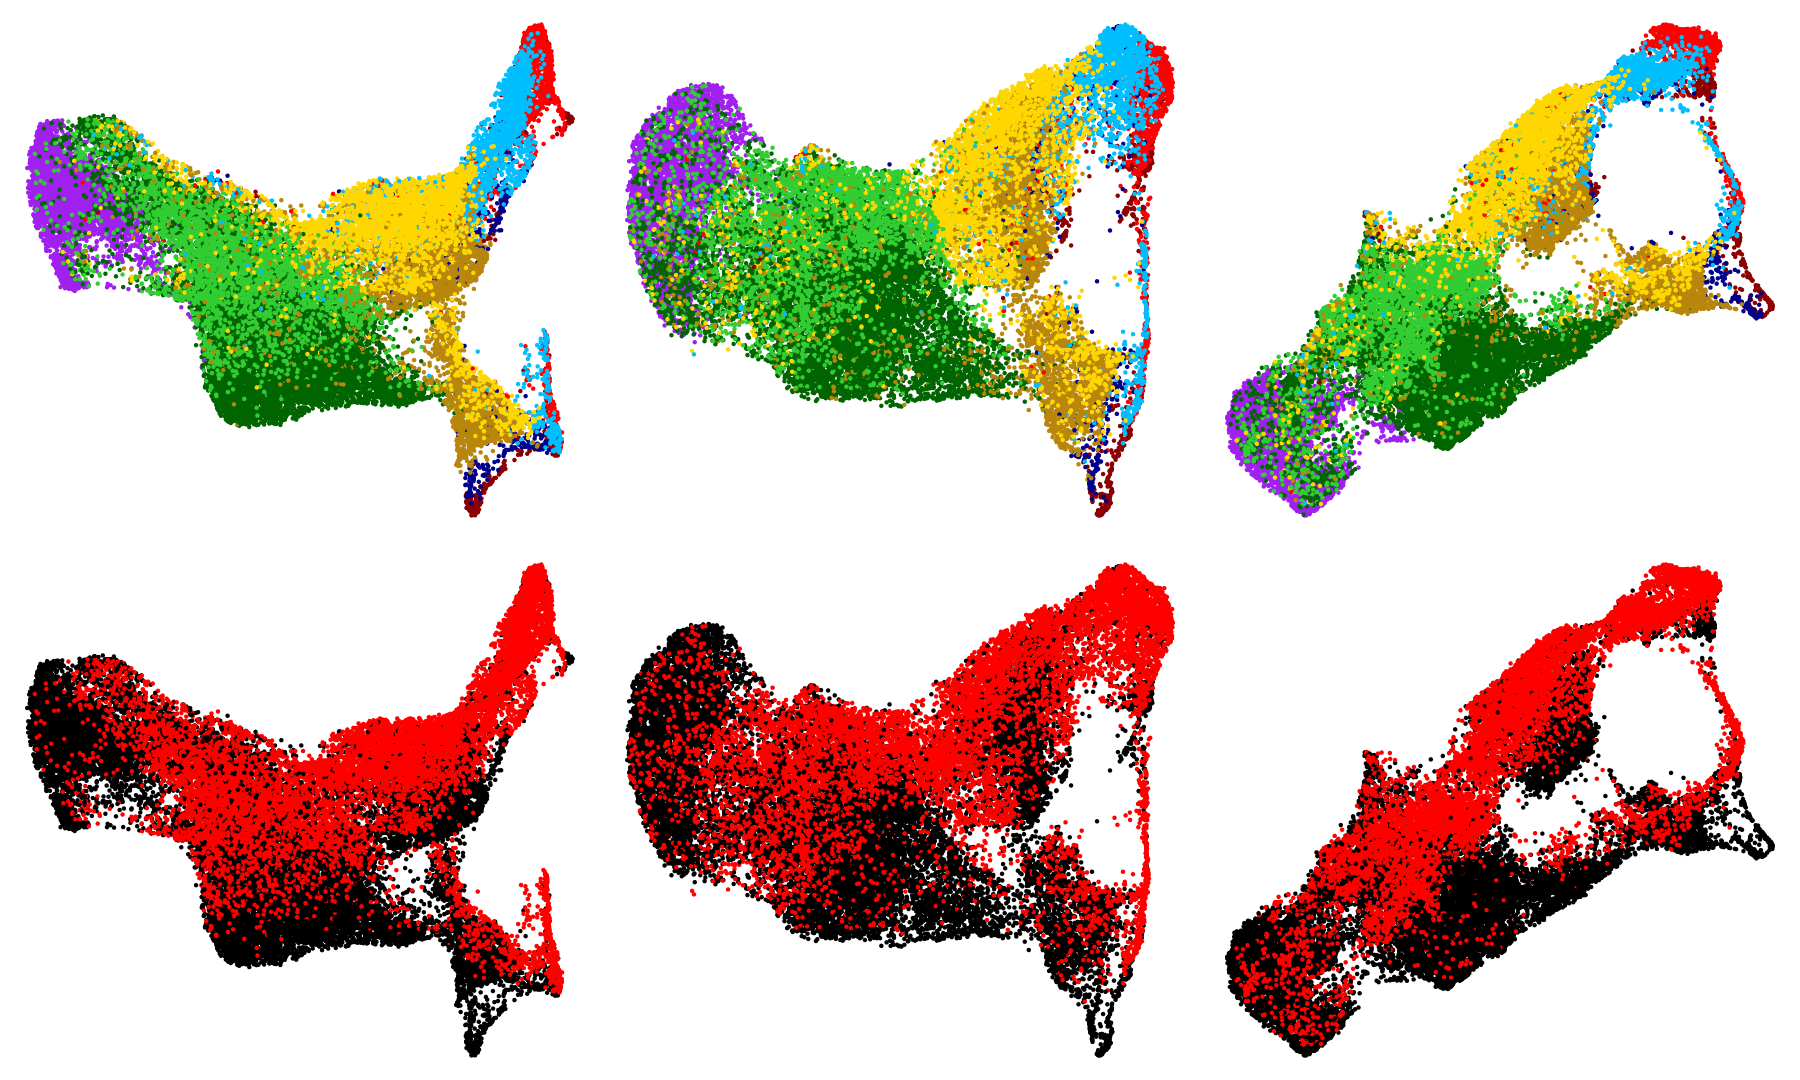

In [44]:
options(repr.plot.width=15, repr.plot.height=9)
ggarrange(plot_umap(merge(meta, rna_umap, by='cell')), 
          plot_umap(merge(meta, atac_umap[,UMAP2:=UMAP2*-1][,UMAP1:=UMAP1*-1], by='cell')), 
          plot_umap(merge(meta, mofa_umap, by='cell')),
         ncol=3)

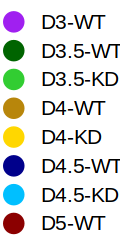

In [55]:
umap.dt = merge(meta, rna_umap, by='cell')
umap.dt$day_genotype = paste0(umap.dt$day, '-', umap.dt$genotype)
umap.dt$day_genotype = gsub('KO', 'KD', umap.dt$day_genotype)
umap.dt$day_genotype = factor(umap.dt$day_genotype, levels=c('D3-WT','D3.5-WT','D3.5-KD','D4-WT','D4-KD','D4.5-WT','D4.5-KD','D5-WT','D5-KD'))

p1 = get_legend(ggplot(umap.dt, aes(UMAP1, UMAP2, col=day_genotype)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=c('D3-WT' = 'purple', 
                                    'D3.5-WT' = 'darkgreen', 
                                    'D3.5-KD' = 'limegreen',
                                    'D4-WT' = 'darkgoldenrod', 
                                    'D4-KD' = 'gold',
                                    'D4.5-WT' = 'darkblue',
                                    'D4.5-KD' = 'deepskyblue', 
                                    'D5-WT' = 'darkred',
                                    'D5-KD' = 'red'
                                   ), name='') +
        guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
        #ggtitle('Day-Genotype') +
        theme_void() +
        theme(text=element_text(size=text_size), 
             plot.title=element_text(size=title_size), 
             legend.position='right'))

options(repr.plot.width=1, repr.plot.height=2)
ggarrange(p1)

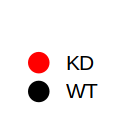

In [60]:
umap.dt = merge(meta, rna_umap, by='cell')
umap.dt$day_genotype = paste0(umap.dt$day, '-', umap.dt$genotype)
umap.dt$day_genotype = gsub('KO', 'KD', umap.dt$day_genotype)
umap.dt$day_genotype = factor(umap.dt$day_genotype, levels=c('D3-WT','D3.5-WT','D3.5-KD','D4-WT','D4-KD','D4.5-WT','D4.5-KD','D5-WT','D5-KD'))
umap.dt$genotype = gsub('KO', 'KD', umap.dt$genotype)

p1 = get_legend(ggplot(umap.dt, aes(UMAP1, UMAP2, col=genotype)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=c(opts$genotype.colors, 'KD' = 'red'), name='') + 
        guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
        #ggtitle('Genotype') +
        theme_void() +
        theme(text=element_text(size=text_size), 
             plot.title=element_text(size=title_size),
             legend.position='right'))

options(repr.plot.width=1, repr.plot.height=1)
ggarrange(p1)